# Data Cleaning

Checks for: duplicates, negative values, absurd fares/extras, absurd distances, absurd speeds, absurd durations, absurd fare/mile.  
Outputs `taxidata_clean.csv`.

In [121]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/taxidata.csv", na_values=["NA", ""])
df["trip_start_timestamp"] = pd.to_datetime(df["trip_start_timestamp"])
df["trip_end_timestamp"] = pd.to_datetime(df["trip_end_timestamp"])
N_RAW = len(df)
print(f"Raw rows: {N_RAW:,}")
df.head(3)

Raw rows: 400,000


,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,b1c0e48bf0f924f81a6e30f69506b0e77da3ce77,64848e03709152785ab1f99953fe601c44acad3e49fc5a...,2014-03-13 19:45:00+00:00,2014-03-13 19:45:00+00:00,480,0.9,1.703184e+10,1.703128e+10,32,28,...,0.0,8.25,Credit Card,Dispatch Taxi Affiliation,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224)
1,2cbd1251af23c02e9ea5ba577f39e0a441b64fc8,131107e9f0f51399bdc9e8c2eb94fce500bdf22daeb1f8...,2014-11-14 14:15:00+00:00,2014-11-14 14:30:00+00:00,720,1.9,1.703132e+10,1.703108e+10,32,8,...,0.0,10.45,Credit Card,Taxi Affiliation Services,41.877406,-87.621972,POINT (-87.6219716519 41.8774061234),41.907520,-87.626659,POINT (-87.6266589003 41.90752007470001)
2,4f56cd65f17297fbf607913db89b557746e4411d,8d132b3939f74abd910a18b15a7e28b2f48b8b7bd7d985...,2014-08-05 23:45:00+00:00,2014-08-05 23:45:00+00:00,660,0.3,NaN,NaN,22,16,...,1.0,14.85,Cash,Taxi Affiliation Services,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.953582,-87.723452,POINT (-87.7234523905 41.9535821253)


## 1. Duplicates

In [122]:
n_before = len(df)
df = df.drop_duplicates(subset="unique_key", keep="first")
removed_duplicates = n_before - len(df)
print(f"Dropped {removed_duplicates} duplicate rows")

Dropped 0 duplicate rows


## 2. Negative / zero values

In [123]:
money_cols = ["fare", "tips", "tolls", "extras", "trip_total"]
for c in ["trip_seconds", "trip_miles"] + money_cols:
    n_neg = (df[c] < 0).sum()
    n_zero = (df[c] == 0).sum()
    print(f"{c:20s}  neg: {n_neg:>5}   zero: {n_zero:>6}")

n_before = len(df)
df = df[
    (df["trip_seconds"] > 0)
    & (df["trip_miles"] > 0)
    & (df["fare"] > 0)
    & (df["tips"] >= 0)
    & (df["tolls"] >= 0)
    & (df["extras"] >= 0)
    & (df["trip_total"] > 0)
]
removed_negative_zero = n_before - len(df)
print(f"\nDropped {removed_negative_zero:,} rows")

trip_seconds          neg:     0   zero:    591
trip_miles            neg:     0   zero:      0
fare                  neg:     0   zero:     99
tips                  neg:     0   zero: 235486
tolls                 neg:     0   zero: 399945
extras                neg:     0   zero: 242898
trip_total            neg:     0   zero:     97

Dropped 689 rows


## 3. Absurd fares & extras

In [124]:
print("Top 5 fares:")
print(df.nlargest(5, "fare")[["fare", "trip_miles", "trip_seconds", "extras"]].to_string())
print("\nTop 5 extras:")
print(df.nlargest(5, "extras")[["extras", "fare", "trip_miles"]].to_string())

Top 5 fares:
           fare  trip_miles  trip_seconds  extras
267023  8004.10         1.6          1187    0.00
348613  8002.52         0.9           784    0.04
222150  6666.66       333.0            53    0.00
290539  5004.10         1.2          3782    0.00
351168  3001.30         0.4           458    0.00

Top 5 extras:
         extras   fare  trip_miles
87508   6667.66   8.05         2.2
130289  5555.50   8.45         2.4
159517  4446.44   6.05         1.1
151834  4443.32  10.65         3.0
382835  4411.16  24.25         6.7


In [125]:
n_before = len(df)
df = df[(df["fare"] <= 500) & (df["extras"] <= 100)]
removed_fares_extras = n_before - len(df)
print(f"Dropped {removed_fares_extras} rows with fare > $500 or extras > $100")

Dropped 21 rows with fare > $500 or extras > $100


## 4. Absurd distances

In [126]:
print("Top 5 distances:")
print(df.nlargest(5, "trip_miles")[["trip_miles", "trip_seconds", "fare"]].to_string())

Top 5 distances:
        trip_miles  trip_seconds   fare
360506       995.4          1080  26.00
19366        972.8           900  23.85
8841         821.8          2700  40.25
83344        812.6          2640  23.05
8800         790.9          1380  19.05


In [127]:
n_before = len(df)
df = df[df["trip_miles"] <= 100]
removed_distances = n_before - len(df)
print(f"Dropped {removed_distances} rows with trip_miles > 100")

Dropped 47 rows with trip_miles > 100


## 5. Absurd trip durations

In [128]:
print("Top 5 durations:")
top5 = df.nlargest(5, "trip_seconds").copy()
top5["trip_hours"] = top5["trip_seconds"] / 3600
print(top5[["trip_hours", "trip_miles", "fare"]].to_string())

Top 5 durations:
        trip_hours  trip_miles   fare
205702   23.467222       10.17  27.00
321902   22.784722        3.68  11.50
374662   22.380000        1.17   7.25
214543   22.169167        1.42   7.25
311688   22.060278       13.58  35.25


In [129]:
n_before = len(df)
df = df[df["trip_seconds"] <= 14400]  # 4 hours
removed_durations = n_before - len(df)
print(f"Dropped {removed_durations} rows with trip > 4 hours")

Dropped 99 rows with trip > 4 hours


## 6. Absurd fare per mile

In [130]:
df["fare_per_mile"] = df["fare"] / df["trip_miles"]

# Short trips have high fare/mile due to the ~$3.25 flag drop, so
# we look at the distribution in distance buckets.
print("Fare/mile by distance bucket:")
bins = [0, 0.5, 1, 2, 5, 100]
labels = ["0-0.5mi", "0.5-1mi", "1-2mi", "2-5mi", "5-100mi"]
df["dist_bin"] = pd.cut(df["trip_miles"], bins=bins, labels=labels)
stats = df.groupby("dist_bin", observed=True)["fare_per_mile"].agg(["count", "mean", "median", "max"])
print(stats.to_string())

print(f"\nfare/mile > $100 (trips > 1 mi): {((df['fare_per_mile'] > 100)).sum()}")
print(f"fare/mile > $50  (trips > 2 mi): {((df['fare_per_mile'] > 50) & (df['trip_miles'] > 2)).sum()}")
print(f"fare/mile < $0.50 (any trip):    {(df['fare_per_mile'] < 0.50).sum()}")

Fare/mile by distance bucket:
           count       mean     median           max
dist_bin                                            
0-0.5mi    60546  54.927024  53.750000  10000.000000
0.5-1mi    81634  10.098757   7.236842    149.166667
1-2mi     105293   6.038634   5.166667     71.366667
2-5mi      78132   3.649381   3.580402     46.309524
5-100mi    73539   2.547996   2.535714     12.954545

fare/mile > $100 (trips > 1 mi): 4820
fare/mile > $50  (trips > 2 mi): 0
fare/mile < $0.50 (any trip):    207


In [131]:
bad_fpm = (
    ((df["fare_per_mile"] > 100) & (df["trip_miles"] > 1))
    | (df["fare_per_mile"] < 0.50)
)

n_before = len(df)
df = df[~bad_fpm]
removed_fare_per_mile = n_before - len(df)
print(f"Dropped {removed_fare_per_mile:,} rows with absurd fare/mile")
df.drop(columns=["fare_per_mile", "dist_bin"], inplace=True)

Dropped 207 rows with absurd fare/mile


# 7. Save clean data

In [132]:
df.to_csv("data/taxidata_clean.csv", index=False)
print(f"Saved taxidata_clean.csv ({len(df):,} rows)")

Saved taxidata_clean.csv (398,937 rows)


## 8. Outliers Removed - Visual Summary

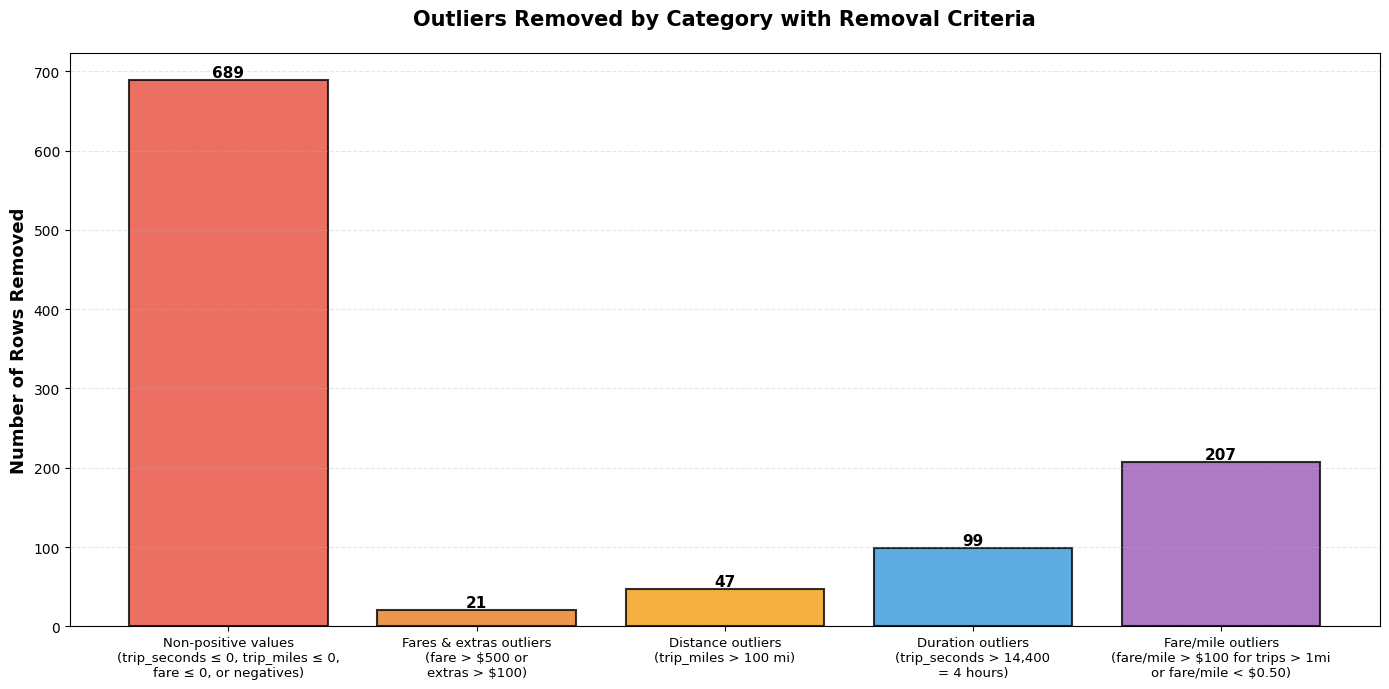

In [133]:
import matplotlib.pyplot as plt

categories = [
    'Non-positive values\n(trip_seconds ≤ 0, trip_miles ≤ 0,\nfare ≤ 0, or negatives)',
    'Fares & extras outliers\n(fare > $500 or\nextras > $100)',
    'Distance outliers\n(trip_miles > 100 mi)',
    'Duration outliers\n(trip_seconds > 14,400\n= 4 hours)',
    'Fare/mile outliers\n(fare/mile > $100 for trips > 1mi\nor fare/mile < $0.50)'
]
removed_counts = [
    removed_negative_zero,
    removed_fares_extras,
    removed_distances,
    removed_durations,
    removed_fare_per_mile
]

fig, ax = plt.subplots(figsize=(14, 7))

colors = ['#e74c3c', '#e67e22', '#f39c12', '#3498db', '#9b59b6', '#1abc9c']
bars = ax.bar(range(len(categories)), removed_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Number of Rows Removed', fontsize=13, fontweight='bold')
ax.set_title('Outliers Removed by Category with Removal Criteria', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, fontsize=9.5, ha='center')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, val in zip(bars, removed_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Entries Removed by Year (2014 vs 2019)

In [134]:
# Load original data to get year distribution before cleaning
df_original = pd.read_csv("data/taxidata.csv", na_values=["NA", ""])
df_original["trip_start_timestamp"] = pd.to_datetime(df_original["trip_start_timestamp"])

# Year counts in original vs cleaned data
original_years = df_original["trip_start_timestamp"].dt.year.value_counts().sort_index()
clean_years = df["trip_start_timestamp"].dt.year.value_counts().sort_index()

# Calculate removed entries by year
removed_2014 = original_years[2014] - clean_years[2014]
removed_2019 = original_years[2019] - clean_years[2019]

print("Entries Removed by Year:")
print(f"\n2014:")
print(f"  Original: {original_years[2014]:,}")
print(f"  Clean:    {clean_years[2014]:,}")
print(f"  Removed:  {removed_2014:,} ({removed_2014/original_years[2014]*100:.2f}%)")

print(f"\n2019:")
print(f"  Original: {original_years[2019]:,}")
print(f"  Clean:    {clean_years[2019]:,}")
print(f"  Removed:  {removed_2019:,} ({removed_2019/original_years[2019]*100:.2f}%)")

print(f"\nTotal removed: {removed_2014 + removed_2019:,}")

Entries Removed by Year:

2014:
  Original: 200,000
  Clean:    199,282
  Removed:  718 (0.36%)

2019:
  Original: 200,000
  Clean:    199,655
  Removed:  345 (0.17%)

Total removed: 1,063
